In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import csv
from collections import Counter

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Summary

The notebook is similar to <b>Profile of Loyal Donors.ipynb</b>. Except here, only donors who are actual persons are studied.

In [3]:
question1 = pd.read_csv('sqldata/question1.csv',dtype = str)
question1 = question1[question1['TYPE']=='1']  #Only business partners who are people
question1 = question1[['PARTNER','ZZAMNT_PAYED','ORDER_GUID']]
print(question1.shape)
df = pd.DataFrame.from_dict(Counter((question1['ORDER_GUID'])), orient='index').reset_index()
df = df.rename(columns={'index':'ORDER_GUID', 0:'ORDER_GUID_COUNT'})
question1 = pd.merge(question1,df,on='ORDER_GUID',how='inner')
question1['ZZAMNT_PAYED'] = question1['ZZAMNT_PAYED'].astype('float64')
question1['ORDER_GUID_COUNT'] = question1['ORDER_GUID_COUNT'].astype('int32')
print(question1['ZZAMNT_PAYED'].sum())
question1['ZZAMNT_PAYED_NORM'] = question1['ZZAMNT_PAYED']/question1['ORDER_GUID_COUNT']
print(question1['ZZAMNT_PAYED_NORM'].sum())
question1.head()

(115664, 3)
32128222.160000008
24253790.77


,PARTNER,ZZAMNT_PAYED,ORDER_GUID,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
0,0200000097,40.0,2294EB49A90B1ED5B8CFEFA76FB78A59,1,40.0
1,0200000099,40.0,2294EB49A90D1ED7AFAB093C353D4011,1,40.0
2,0200000108,250.0,2294EB49A90B1ED5B8CD6AF498800A59,1,250.0
3,0200000108,800.0,2294EB49A90B1ED5B8CBB3B5193A4A59,1,800.0
4,0200000108,250.0,2294EB49A90B1ED5B8CD071000124A59,1,250.0


In [4]:
#Check for inconsistency among the data. One inconsistency could be if the donation sum is less than 0
question1['ZZAMNT_PAYED'] = question1['ZZAMNT_PAYED'].astype('float64')
question1[question1['ZZAMNT_PAYED'] < 0]

,PARTNER,ZZAMNT_PAYED,ORDER_GUID,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
111532,0201222693,-675.0,2294EB49A90D1ED7A78F46F0734B400F,2,-337.5
111533,0201222694,-675.0,2294EB49A90D1ED7A78F46F0734B400F,2,-337.5


As you can see there are two entries where donation amount is -675 Euro. This is also a joint donation. This data needs to be removed.

In [5]:
question1 = question1[question1['ZZAMNT_PAYED'] >= 0]
question1.reset_index(drop=True,inplace=True)
print(question1['ZZAMNT_PAYED'].sum())
print(question1['ZZAMNT_PAYED_NORM'].sum())
print('Number of donors: '+str(len(set(question1['PARTNER']))))
print(question1.shape)
question1.head()

32129572.160000008
24254465.77
Number of donors: 50105
(115662, 5)


,PARTNER,ZZAMNT_PAYED,ORDER_GUID,ORDER_GUID_COUNT,ZZAMNT_PAYED_NORM
0,0200000097,40.0,2294EB49A90B1ED5B8CFEFA76FB78A59,1,40.0
1,0200000099,40.0,2294EB49A90D1ED7AFAB093C353D4011,1,40.0
2,0200000108,250.0,2294EB49A90B1ED5B8CD6AF498800A59,1,250.0
3,0200000108,800.0,2294EB49A90B1ED5B8CBB3B5193A4A59,1,800.0
4,0200000108,250.0,2294EB49A90B1ED5B8CD071000124A59,1,250.0


Without normalizing the donation sum, you see that the LUF received 32,129,572.16 Euro in total. <br>
After normaling the donation sum, you can see that the LUF actually received <b>24,254,465.77</b> Euro in total since 2002. <br>
LUF received 115,662 number of valid donations from 50,105 donors since 2002.

In the next couple of cells we calculate the statistics for each donors like: <br>
-  DONATION_COUNT: Number of times a donor has donated to LUF.
-  DONATION_MEAN: Mean donation sum of a donor.
-  DONATION_SUM: Total donation sum of a donor.
-  DONATION_CV: Coefficient of variation of donation sum. <br> 
etc

In [6]:
aggregate = pd.DataFrame(group.describe().rename(columns={'ZZAMNT_PAYED_NORM':name}).squeeze()
                         for name, group in question1[['PARTNER','ZZAMNT_PAYED_NORM']].groupby('PARTNER'))
aggregate['PARTNER'] = aggregate.index
aggregate = aggregate.reset_index(drop=True)
aggregate = aggregate.rename(columns={'count':'DONATION_COUNT',
                                      'mean':'DONATION_MEAN',
                                      'std':'DONATION_STD',
                                      'min':'DONATION_MIN',
                                      '25%':'DONATION_25',
                                      '50%':'DONATION_50',
                                      '75%':'DONATION_75',
                                      'max':'DONATION_MAX'})
                                      
front = aggregate['PARTNER']
aggregate.drop(labels=['PARTNER'], axis=1,inplace = True)
aggregate.insert(0, 'PARTNER', front)
aggregate.head()
aggregate.to_csv('aggregate.csv')

In [7]:
donor_amount_stats = aggregate
donor_amount_stats['DONATION_SUM'] = donor_amount_stats['DONATION_COUNT'] * donor_amount_stats['DONATION_MEAN']
donor_amount_stats['DONATION_CV'] = donor_amount_stats['DONATION_STD']/donor_amount_stats['DONATION_MEAN']
donor_amount_stats['DONATION_COUNT'] = donor_amount_stats['DONATION_COUNT'].astype(int)
print(donor_amount_stats.shape)
donor_amount_stats.head()

(50105, 11)


,PARTNER,DONATION_COUNT,DONATION_MEAN,DONATION_STD,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV
0,0200000097,1,40.00,NaN,40.0,40.0,40.00,40.00,40.0,40.00,NaN
1,0200000099,1,40.00,NaN,40.0,40.0,40.00,40.00,40.0,40.00,NaN
2,0200000108,6,557.28,262.561974,250.0,312.5,621.84,785.92,800.0,3343.68,0.471149
3,0200000129,1,50.00,NaN,50.0,50.0,50.00,50.00,50.0,50.00,NaN
4,0200000131,2,20.00,0.000000,20.0,20.0,20.00,20.00,20.0,40.00,0.000000


ADRC is a table that contains the address information of the business partners. <br>
BUT000 is a table that contains all the available information of the business partners like date of birth, sex, language, nationality, country, date of death etc. <br>
BUT020 is the links ADRC with BUT000. <br>
<img src="Images/Q1_table.png">

After merging these 3 tables, we'll get few more features that will help in profiling loyal donors such as:<br>
-  <b>ZZGEBOORTEJAAR</b>: Date of birth of the donors. This field has many missing/invalid values.
-  <b>TITLE_ACADEMDIC</b>: Contains the education profile of donors, if known. This field also has many missing values.
-  <b>TITLE</b>: Contains the title of donors.
-  <b>POST_CODE</b>: Contains the postal id location from where donation is carried out.
-  <b>COUNTRY</b>: Contains the country from where donation is carried out.

In [8]:
adrc = pd.read_csv('sqldata/20190102_ADRC.csv',dtype = str,sep=';')
adrc = adrc.rename(columns = {'POST_CODE1':'POST_CODE'})
adrc['POST_CODE'] = adrc['POST_CODE'].str.strip()#remove 'move down a line'(\r)
print(adrc.shape)
adrc.head()

(66150, 4)


,ADDRNUMBER,COUNTRY,DEFLT_COMM,POST_CODE
0,0007220702,BE,LET,8870
1,0007220705,BE,LET,3140
2,0007220708,BE,LET,3140
3,0007220711,BE,LET,8870
4,0007220713,BE,LET,8870


In [9]:
but000 = pd.read_csv('sqldata/20190102_BUT000.csv',dtype = str, encoding='latin-1',sep=';') 
but000_cols = ['PARTNER','ZZGEBOORTEJAAR','TYPE','BIRTHPL','BU_LANGU','NATIO','TITLE_ACA1','TITLE']
but000 = but000[but000_cols]
but000 = but000.rename(columns = {'TITLE_ACA1':'TITLE_ACADEMIC'})
print(but000.shape) #There are 72,114 different business partners in total. Among them there are 56,897 donors
but000.head()

(72114, 8)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE
0,0200000219,1960,1,Leuven,N,BE,NaN,0001
1,0200000424,1968,1,Bonheiden,N,BE,NaN,0001
2,0200000844,1962,1,Leuven,N,BE,NaN,0001
3,0200001162,1966,1,Lier,N,BE,NaN,0001
4,0200001323,1958,1,Kortrijk,N,BE,NaN,0002


In [10]:
but020 = pd.read_csv('sqldata/20190102_BUT020.csv',dtype = str,sep=';')
print(but020.shape)
but020.head()

(66150, 2)


,ADDRNUMBER,PARTNER
0,0007187199,0200257932
1,0007187202,0201054033
2,0007187205,0201054034
3,0007187207,0200058535
4,0007187210,0201054035


Below, we merge the profile of donors data with the aggregations of donation sum carried out before.

In [11]:
donor_temp = pd.merge((pd.merge(but000,but020,on='PARTNER',how='left')),
                      adrc,on='ADDRNUMBER',how='left')
q1_data = pd.merge(donor_temp,donor_amount_stats,on='PARTNER')
print(q1_data.shape)
q1_data.head()

(50105, 22)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_COUNT,DONATION_MEAN,DONATION_STD,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV
0,0200000219,1960,1,Leuven,N,BE,NaN,0001,0007985428,BE,...,1,20.0,NaN,20.0,20.0,20.0,20.0,20.0,20.0,NaN
1,0200000424,1968,1,Bonheiden,N,BE,NaN,0001,0000039287,BE,...,1,25.0,NaN,25.0,25.0,25.0,25.0,25.0,25.0,NaN
2,0200000844,1962,1,Leuven,N,BE,NaN,0001,0000040781,BE,...,1,15.0,NaN,15.0,15.0,15.0,15.0,15.0,15.0,NaN
3,0200001162,1966,1,Lier,N,BE,NaN,0001,0003251413,BE,...,1,50.0,NaN,50.0,50.0,50.0,50.0,50.0,50.0,NaN
4,0200002575,1966,1,Roeselare,N,BE,NaN,0001,0000046646,BE,...,1,100.0,NaN,100.0,100.0,100.0,100.0,100.0,100.0,NaN


In [12]:
donation_stat_cols = ['DONATION_COUNT','DONATION_MEAN','DONATION_STD','DONATION_MIN','DONATION_25','DONATION_50','DONATION_75',
                      'DONATION_MAX','DONATION_SUM','DONATION_CV']
q1_data[donation_stat_cols] = q1_data[donation_stat_cols].astype('float64')
q1_data['ZZGEBOORTEJAAR'] = q1_data['ZZGEBOORTEJAAR'].astype('int32')
q1_data['IS_LOYAL'] = np.where(q1_data['DONATION_COUNT']>=5, 1, 0)#see if the customer is loyal
q1_data['IS_LOYAL2'] = np.where(q1_data['DONATION_COUNT']>=2, 1, 0)#see if the customer is loyal
q1_data['IS_LOYAL10'] = np.where(q1_data['DONATION_COUNT']>=10, 1, 0)#see if the customer is loyal
print(q1_data.shape)
q1_data.head()

(50105, 25)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,IS_LOYAL,IS_LOYAL2,IS_LOYAL10
0,0200000219,1960,1,Leuven,N,BE,NaN,0001,0007985428,BE,...,20.0,20.0,20.0,20.0,20.0,20.0,NaN,0,0,0
1,0200000424,1968,1,Bonheiden,N,BE,NaN,0001,0000039287,BE,...,25.0,25.0,25.0,25.0,25.0,25.0,NaN,0,0,0
2,0200000844,1962,1,Leuven,N,BE,NaN,0001,0000040781,BE,...,15.0,15.0,15.0,15.0,15.0,15.0,NaN,0,0,0
3,0200001162,1966,1,Lier,N,BE,NaN,0001,0003251413,BE,...,50.0,50.0,50.0,50.0,50.0,50.0,NaN,0,0,0
4,0200002575,1966,1,Roeselare,N,BE,NaN,0001,0000046646,BE,...,100.0,100.0,100.0,100.0,100.0,100.0,NaN,0,0,0


In [13]:
from scipy.stats import shapiro #To check for normality
corr_cols = ['DONATION_COUNT','DONATION_MEAN','DONATION_MIN','DONATION_25','DONATION_50','DONATION_75',
             'DONATION_MAX','DONATION_SUM','DONATION_CV','IS_LOYAL2','IS_LOYAL','IS_LOYAL10']
corr_cal = q1_data[corr_cols]
cols = ['DONATION_COUNT','DONATION_MEAN','DONATION_50','DONATION_SUM','IS_LOYAL2','IS_LOYAL','IS_LOYAL10']
shapiro_test_cols = ['shapiro_stat','p_value']
shapiro_test_df = pd.DataFrame(columns = shapiro_test_cols)
for col in cols:
    shapiro_stat,p_value = shapiro(corr_cal[col])
    df = pd.DataFrame([[shapiro_stat,p_value]],columns = shapiro_test_cols,index=[col])
    shapiro_test_df = shapiro_test_df.append(df)

shapiro_test_df

,shapiro_stat,p_value
DONATION_COUNT,0.178174,0.0
DONATION_MEAN,0.024736,0.0
DONATION_50,0.024145,0.0
DONATION_SUM,0.023314,0.0
IS_LOYAL2,0.545634,0.0
IS_LOYAL,0.305297,0.0
IS_LOYAL10,0.176043,0.0


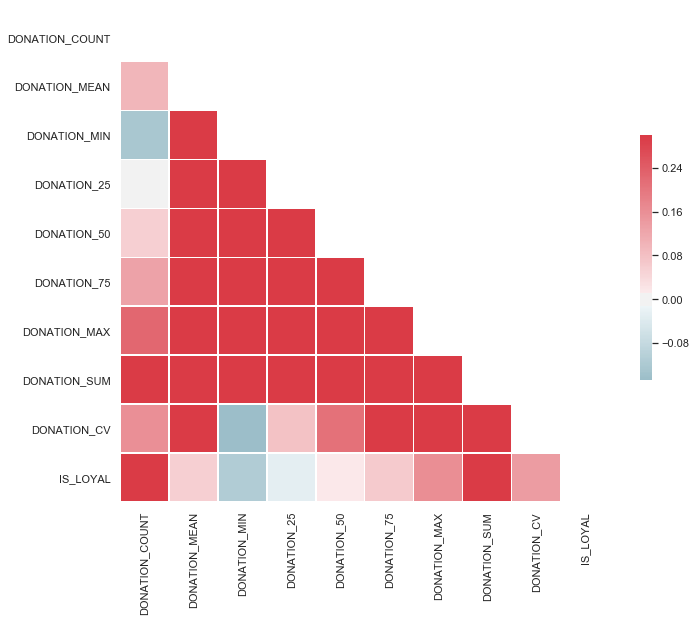

In [14]:
def plot_correlation_heatmap(df):
    corr = df.corr(method='spearman')  #Spearman correlation is used as shapiro test (below) shows data is not normal
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
corr_cols = ['DONATION_COUNT','DONATION_MEAN','DONATION_MIN','DONATION_25','DONATION_50','DONATION_75',
             'DONATION_MAX','DONATION_SUM','DONATION_CV','IS_LOYAL']
corr_cal = q1_data[corr_cols]
plot_correlation_heatmap(corr_cal)#only features (X)

In [15]:
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr
print(spearmanr(corr_cal['DONATION_MEAN'],corr_cal['IS_LOYAL']))
#print(pearsonr(corr_cal['DONATION_MEAN'],corr_cal['IS_LOYAL']))
cols = ['DONATION_MEAN','DONATION_MIN','DONATION_25','DONATION_50','DONATION_75','DONATION_MAX','DONATION_SUM']
spearman_cor_cols = ['IS_LOYAL','P-Value']
spearman_cor_df = pd.DataFrame(columns = spearman_cor_cols)
for col in cols:
    spear_col_stat,p_value = spearmanr(corr_cal[col],corr_cal['IS_LOYAL'])
    df = pd.DataFrame([[spear_col_stat,p_value]],columns=spearman_cor_cols,index=[col])
    spearman_cor_df = spearman_cor_df.append(df)
    
spearman_cor_df['IS_LOYAL'] = spearman_cor_df['IS_LOYAL'].round(4)    
spearman_cor_df

SpearmanrResult(correlation=0.05891576041692472, pvalue=8.899464733981128e-40)


,IS_LOYAL,P-Value
DONATION_MEAN,0.0589,8.899465e-40
DONATION_MIN,-0.1109,7.491549e-137
DONATION_25,-0.0295,4.255722e-11
DONATION_50,0.0165,2.267704e-04
DONATION_75,0.0635,5.933248e-46
DONATION_MAX,0.1632,4.343870e-296
DONATION_SUM,0.4190,0.000000e+00


The above 2 cells is used to answer the question: Does the gift amount play a role for being a loyal donor? <br>
We found the answer to be <b>No</b> as no significant correlation between being a loyal donor & donation statistics such as mean/sum/min etc.

## Loyal Donors
From now onwards we will analyse the profile that is specific to loyal donors. <br>
A loyal donor is someone who has donated to LUF at least 5 times.

In [16]:
loyal_donor = q1_data[q1_data['DONATION_COUNT']>=5]
print(loyal_donor.shape)
loyal_donor.head()

(4121, 25)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,IS_LOYAL,IS_LOYAL2,IS_LOYAL10
6,0200003499,1941,1,Dendermonde,N,BE,0003,0002,0000049649,BE,...,25.0,30.00,40.0,50.0,125.0,270.0,0.756204,1,1,0
7,0200005037,1967,1,Dendermonde,N,BE,NaN,0001,0001045864,BE,...,20.0,25.00,50.0,100.0,160.0,580.0,0.797332,1,1,0
8,0200005221,1941,1,Brugge,N,BE,0003,0002,0000055278,BE,...,15.0,17.50,20.0,30.0,60.0,190.0,0.618841,1,1,0
9,0200006547,1943,1,Aalst,N,BE,0008,0002,0007681446,BE,...,30.0,63.75,137.5,275.0,500.0,2440.0,0.776334,1,1,1
13,0200015505,1950,1,Tienen,N,BE,NaN,0002,0008926470,BE,...,50.0,50.00,1000.0,1000.0,1000.0,5150.0,0.763762,1,1,0


Check the missing values in the data and fill the missing values with appropriate labels

In [17]:
loyal_donor.isna().sum()

PARTNER              0
ZZGEBOORTEJAAR       0
TYPE                 0
BIRTHPL           3082
BU_LANGU          2526
NATIO             2516
TITLE_ACADEMIC    3559
TITLE                2
ADDRNUMBER           2
COUNTRY              2
DEFLT_COMM           2
POST_CODE            9
DONATION_COUNT       0
DONATION_MEAN        0
DONATION_STD         0
DONATION_MIN         0
DONATION_25          0
DONATION_50          0
DONATION_75          0
DONATION_MAX         0
DONATION_SUM         0
DONATION_CV          0
IS_LOYAL             0
IS_LOYAL2            0
IS_LOYAL10           0
dtype: int64

In [18]:
loyal_donor['BIRTHPL'] = loyal_donor['BIRTHPL'].fillna('Unknown')
loyal_donor['BU_LANGU'] = loyal_donor['BU_LANGU'].fillna('Unknown')
loyal_donor['NATIO'] = loyal_donor['NATIO'].fillna('Unknown')
loyal_donor['TITLE_ACADEMIC'] = loyal_donor['TITLE_ACADEMIC'].fillna('Unknown')
loyal_donor['TITLE'] = loyal_donor['TITLE'].fillna('Unknown')
print(loyal_donor.shape)
loyal_donor.head()

(4121, 25)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,IS_LOYAL,IS_LOYAL2,IS_LOYAL10
6,0200003499,1941,1,Dendermonde,N,BE,0003,0002,0000049649,BE,...,25.0,30.00,40.0,50.0,125.0,270.0,0.756204,1,1,0
7,0200005037,1967,1,Dendermonde,N,BE,Unknown,0001,0001045864,BE,...,20.0,25.00,50.0,100.0,160.0,580.0,0.797332,1,1,0
8,0200005221,1941,1,Brugge,N,BE,0003,0002,0000055278,BE,...,15.0,17.50,20.0,30.0,60.0,190.0,0.618841,1,1,0
9,0200006547,1943,1,Aalst,N,BE,0008,0002,0007681446,BE,...,30.0,63.75,137.5,275.0,500.0,2440.0,0.776334,1,1,1
13,0200015505,1950,1,Tienen,N,BE,Unknown,0002,0008926470,BE,...,50.0,50.00,1000.0,1000.0,1000.0,5150.0,0.763762,1,1,0


### Age Profile

In [19]:
loyal_donor['AGE'] = 2019 - loyal_donor['ZZGEBOORTEJAAR']  
cut_points = [0,10,20,30,40,50,60,70,80,90,100,loyal_donor["AGE"].max()]
age_cat_names = ["0-10", "10-20", "20-30", "30-40", "40-50","50-60","60-70","70-80","80-90","90-100","Unknown"]
loyal_donor["AGE_CATEGORY"] = pd.cut(loyal_donor["AGE"],cut_points,labels=age_cat_names)
print(loyal_donor.shape)
loyal_donor.head()

(4121, 27)


,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,IS_LOYAL,IS_LOYAL2,IS_LOYAL10,AGE,AGE_CATEGORY
6,0200003499,1941,1,Dendermonde,N,BE,0003,0002,0000049649,BE,...,40.0,50.0,125.0,270.0,0.756204,1,1,0,78,70-80
7,0200005037,1967,1,Dendermonde,N,BE,Unknown,0001,0001045864,BE,...,50.0,100.0,160.0,580.0,0.797332,1,1,0,52,50-60
8,0200005221,1941,1,Brugge,N,BE,0003,0002,0000055278,BE,...,20.0,30.0,60.0,190.0,0.618841,1,1,0,78,70-80
9,0200006547,1943,1,Aalst,N,BE,0008,0002,0007681446,BE,...,137.5,275.0,500.0,2440.0,0.776334,1,1,1,76,70-80
13,0200015505,1950,1,Tienen,N,BE,Unknown,0002,0008926470,BE,...,1000.0,1000.0,1000.0,5150.0,0.763762,1,1,0,69,60-70


Text(0.5, 1.0, 'Age profile of loyal donors')

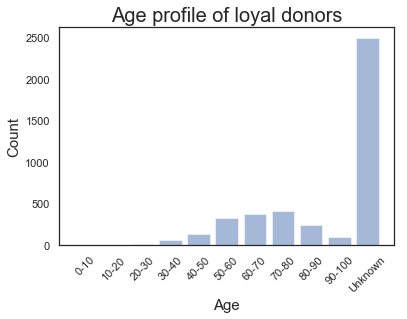

In [20]:
plt.bar(age_cat_names, loyal_donor['AGE_CATEGORY'].value_counts(sort=False), align='center', alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Age',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Age profile of loyal donors',fontsize=20)

Clearly majority of the Age data is missing. <br>
But among the data that is available it can be seen people who are older than 50+ years tend to be a loyal donor.

### Title Profile

Text(0.5, 1.0, 'Titles of loyal donors')

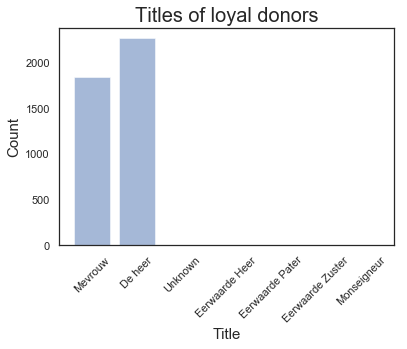

In [21]:
titles=['Mevrouw','De heer','Unknown','Eerwaarde Heer','Eerwaarde Pater','Eerwaarde Zuster','Monseigneur']
loyal_donor['TITLE'].value_counts().sort_index()
plt.bar(titles, loyal_donor['TITLE'].value_counts().sort_index(), align='center', alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Title',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.title('Titles of loyal donors',fontsize=20)

From the data that is available, it can be seen that there are slightly more loyal donors who are men (De heer) than woman (Mevrouw).

### Education Profile

Text(0.5, 1.0, 'Education/Background profile of loyal donors')

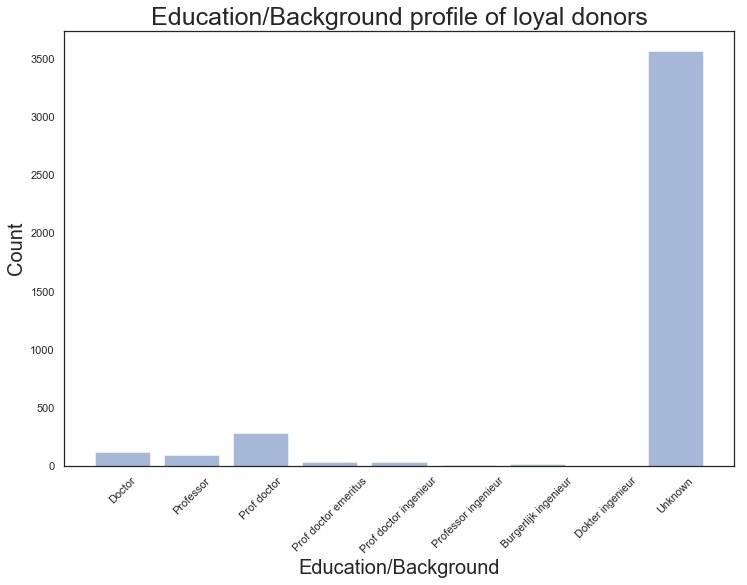

In [22]:
fig = plt.figure(figsize = (12,8))
academic_titles = ['Doctor','Professor','Prof doctor','Prof doctor emeritus','Prof doctor ingenieur','Professor ingenieur','Burgerlijk ingenieur','Dokter ingenieur','Unknown']
loyal_donor['TITLE_ACADEMIC'].value_counts().sort_index()
plt.bar(academic_titles, loyal_donor['TITLE_ACADEMIC'].value_counts().sort_index(), align='center', alpha=0.5)
plt.xticks(rotation=45)
plt.xlabel('Education/Background',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.title('Education/Background profile of loyal donors',fontsize=25)

A proper conclusion could not be drawn about the education profile of loyal donors due to the amount of missing data. <br>

The below cell tries to answer the question: Does a loyal donor always give the same amount?

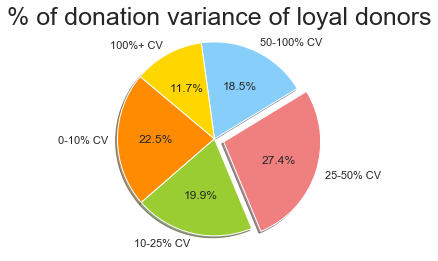

In [23]:
labels = ['0-10% CV','10-25% CV','25-50% CV','50-100% CV','100%+ CV']
donation_cv = loyal_donor['DONATION_CV']
ranges = [0,0.10,0.25,0.50,1,10]
sizes = donation_cv.value_counts(bins=ranges,sort=False)
colors = ['darkorange', 'yellowgreen', 'lightcoral', 'lightskyblue','gold']
explode = np.where(sizes==sizes.max(), 0.1, 0.0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('% of donation variance of loyal donors',fontsize=25)
plt.axis('equal')
plt.show()

Most of the donors usually donate similar amount. As most of them have moderate Coefficient of Variation (CV).

## Location Profile

#### Location Profile - Country

In [24]:
ld = loyal_donor
ld['DONATION_COUNT'] = ld['DONATION_COUNT'].astype('int32')
column_names = ['Region','No_of_Loyal_Donors','Donation_Count','Avg_Donation_Freq','Total_Donation','Avg_Donation']
donation_stats = pd.DataFrame(columns = column_names)
for reg,count in ld['COUNTRY'].value_counts().iteritems():
    donation_stats.loc[len(donation_stats)] = [reg,format(count,",d"),format(ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum(),",d"),format(ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum()/count,",.2f"),format(round(ld[ld['COUNTRY'] == reg]['DONATION_SUM'].sum(),2),",.2f"),format(round(ld[ld['COUNTRY'] == reg]['DONATION_SUM'].sum()/ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum(),2),",.2f")]
    #print(reg,count,ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum(),ld[ld['COUNTRY'] == reg]['DONATION_SUM'].sum(),ld[ld['COUNTRY'] == reg]['DONATION_SUM'].sum()/ld[ld['COUNTRY'] == reg]['DONATION_COUNT'].sum())

donation_stats.loc[len(donation_stats)] = ['Outside BE',format(ld[ld['COUNTRY'] != 'BE']['COUNTRY'].size,",d"),format(ld[ld['COUNTRY'] != 'BE']['DONATION_COUNT'].sum(),",d"),format(ld[ld['COUNTRY'] != 'BE']['DONATION_COUNT'].sum()/ld[ld['COUNTRY'] != 'BE']['COUNTRY'].size,",.2f"),format(round(ld[ld['COUNTRY'] != 'BE']['DONATION_SUM'].sum(),2),",.2f"),format(round(ld[ld['COUNTRY'] != 'BE']['DONATION_SUM'].sum()/ld[ld['COUNTRY'] != 'BE']['DONATION_COUNT'].sum(),2),",.2f")]
#put the last row ('Outside BE') to first row
donation_stats = donation_stats.apply(np.roll, shift=1)
#swap the first two rows ('Outside BE' & 'BE')
b, c = donation_stats.iloc[0], donation_stats.iloc[1]
temp = donation_stats.iloc[0].copy()
donation_stats.iloc[0] = c
donation_stats.iloc[1] = temp
donation_stats

,Region,No_of_Loyal_Donors,Donation_Count,Avg_Donation_Freq,Total_Donation,Avg_Donation
0,BE,"4,083","55,951",13.70,"11,321,469.88",202.35
1,Outside BE,38,518,13.63,"2,167,321.36","4,184.02"
2,NL,16,219,13.69,"17,666.36",80.67
3,CH,8,142,17.75,"1,779,340.00","12,530.56"
4,LU,3,38,12.67,"5,490.00",144.47
5,DE,3,49,16.33,"350,660.00","7,156.33"
6,FR,2,10,5.00,290.00,29.00
7,GR,2,10,5.00,370.00,37.00
8,US,1,6,6.00,"1,025.00",170.83
9,SE,1,6,6.00,855.00,142.50


Not surprisingly, Belgium (BE) tops the list with the highest number of loyal donors, the highest number of donations received, and the total donation sum received. <br>
Surprisingly, loyal donors donating from <b>outside Belgium</b> donate on an average <i>twenty times</i? more per donation than loyal donors donating from <b>Belgium</b>.

In [25]:
country = loyal_donor['COUNTRY'].value_counts()
country['BE']/country.sum()

0.9912600145666424

About 99% of the loyal donors donate from Belgium

In [26]:
def province (be):
    if 1000 <= be['POST_CODE'] <= 1299 :
        return'Brussels' 
    if 1300 <= be['POST_CODE'] <= 1499 :
        return 'Walloon Brabant'
    if 1500 <= be['POST_CODE'] <= 1999 :
        return 'Flemish Brabant'
    if 2000 <= be['POST_CODE'] <= 2999 :
        return 'Antwerp'
    if 3000 <= be['POST_CODE'] <= 3499 :
        return 'Flemish Brabant'
    if 3500 <= be['POST_CODE'] <= 3999 :
        return 'Limburg'
    if 4000 <= be['POST_CODE'] <= 4999 :
        return 'Liege'
    if 5000 <= be['POST_CODE'] <= 5999 :
        return 'Namur'
    if 6000 <= be['POST_CODE'] <= 6599 :
        return 'Hainaut'
    if 6600 <= be['POST_CODE'] <= 6999 :
        return 'Luxembourg'
    if 7000 <= be['POST_CODE'] <= 7999 :
        return 'Hainaut'
    if 8000 <= be['POST_CODE'] <= 8999 :
        return 'West Flanders'
    if 9000 <= be['POST_CODE'] <= 9999 :
        return 'East Flanders'
    return 'Unknown'

be_loyal_donor = loyal_donor[loyal_donor['COUNTRY']=='BE']
be_loyal_donor['POST_CODE'] = be_loyal_donor['POST_CODE'].fillna(3000)
be_loyal_donor['POST_CODE'] = be_loyal_donor['POST_CODE'].astype('int32')
be_loyal_donor['DONATION_COUNT'] = be_loyal_donor['DONATION_COUNT'].astype('int32')
be_loyal_donor['PROVINCE'] = be_loyal_donor.apply(province,axis=1)

In [27]:
df = loyal_donor[loyal_donor['COUNTRY']=='BE']
df['POST_CODE'] = df['POST_CODE'].fillna(30000)
df[df['POST_CODE']==30000]

,PARTNER,ZZGEBOORTEJAAR,TYPE,BIRTHPL,BU_LANGU,NATIO,TITLE_ACADEMIC,TITLE,ADDRNUMBER,COUNTRY,...,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,IS_LOYAL,IS_LOYAL2,IS_LOYAL10,AGE,AGE_CATEGORY
777,0200011416,1928,1,Gent,N,BE,0002,0002,0007163370,BE,...,30.0,30.00,50.0,200.0,0.244949,1,1,0,91,90-100
1322,0200026241,1926,1,Gent,N,BE,0007,0002,0001244089,BE,...,15.0,21.25,25.0,270.0,0.247340,1,1,1,93,90-100
7689,0200311306,1968,1,Ninove,N,BE,Unknown,0001,0001096792,BE,...,50.0,90.00,250.0,630.0,0.813973,1,1,0,51,50-60
9826,0200341346,1963,1,Asse,N,BE,Unknown,0001,0005534424,BE,...,100.0,100.00,3500.0,4080.0,2.369526,1,1,0,56,50-60
33744,0201070656,1930,1,Unknown,Unknown,Unknown,Unknown,0002,0007240009,BE,...,500.0,500.00,625.0,3625.0,0.091233,1,1,0,89,80-90
33745,0201070657,0,1,Unknown,Unknown,Unknown,Unknown,0001,0007240012,BE,...,500.0,500.00,625.0,3625.0,0.091233,1,1,0,2019,Unknown
34346,0201071359,0,1,Unknown,Unknown,Unknown,Unknown,0001,0007242580,BE,...,15.0,21.25,25.0,270.0,0.247340,1,1,1,2019,Unknown


In [28]:
be_loc_vis_cols = ['PARTNER','POST_CODE','COUNTRY','PROVINCE','DONATION_COUNT','DONATION_MEAN','DONATION_STD','DONATION_MIN','DONATION_25',
                'DONATION_50','DONATION_75','DONATION_MAX','DONATION_SUM','DONATION_CV']
be_visualization_data = be_loyal_donor[be_loc_vis_cols]
print(be_visualization_data.shape)
city = pd.read_csv('ZIP_CITY_BE.csv', encoding='latin-1')
be_visualization_data = pd.merge(be_visualization_data,city,on='POST_CODE',how='inner')
print(be_visualization_data.shape)
be_visualization_data.head()

(4083, 14)
(4083, 15)


,PARTNER,POST_CODE,COUNTRY,PROVINCE,DONATION_COUNT,DONATION_MEAN,DONATION_STD,DONATION_MIN,DONATION_25,DONATION_50,DONATION_75,DONATION_MAX,DONATION_SUM,DONATION_CV,CITY
0,0200003499,3360,BE,Flemish Brabant,5,54.000000,40.835034,25.0,30.0,40.0,50.0,125.0,270.0,0.756204,Bierbeek
1,0200279709,3360,BE,Flemish Brabant,10,72.000000,38.239014,30.0,50.0,50.0,100.0,150.0,720.0,0.531097,Bierbeek
2,0200002775,3360,BE,Flemish Brabant,7,116.428571,90.678658,50.0,75.0,100.0,100.0,315.0,815.0,0.778835,Bierbeek
3,0200006395,3360,BE,Flemish Brabant,159,40.166667,52.000994,7.5,7.5,15.0,50.0,250.0,6386.5,1.294631,Bierbeek
4,0200013673,3360,BE,Flemish Brabant,11,284.545455,166.214538,50.0,175.0,250.0,440.0,500.0,3130.0,0.584141,Bierbeek


#### Location Profile - Province (Belgium)

In [29]:
bld = be_visualization_data
bep_column_names = ['Province','No_of_Loyal_Donors','Donation_Count','Avg_Donation_Freq','Total_Donation','Avg_Donation']
bep_donation_stats = pd.DataFrame(columns = bep_column_names)
for prov,count in bld['PROVINCE'].value_counts().iteritems():
    bep_donation_stats.loc[len(bep_donation_stats)] = [prov,format(count,",d"),format(bld[bld['PROVINCE'] == prov]['DONATION_COUNT'].sum(),",d"),format(bld[bld['PROVINCE'] == prov]['DONATION_COUNT'].sum()/count,",.2f"),format(round(bld[bld['PROVINCE'] == prov]['DONATION_SUM'].sum(),2),",.2f"),format(round(bld[bld['PROVINCE'] == prov]['DONATION_SUM'].sum()/bld[bld['PROVINCE'] == prov]['DONATION_COUNT'].sum(),2),",.2f")]
bep_donation_stats 

,Province,No_of_Loyal_Donors,Donation_Count,Avg_Donation_Freq,Total_Donation,Avg_Donation
0,Flemish Brabant,"1,929","26,738",13.86,"6,029,694.47",225.51
1,Antwerp,766,"11,455",14.95,"2,474,280.18",216.00
2,West Flanders,468,"5,661",12.10,"1,078,126.50",190.45
3,East Flanders,466,"5,724",12.28,"713,155.71",124.59
4,Limburg,347,"4,631",13.35,"495,712.88",107.04
5,Brussels,71,"1,155",16.27,"447,222.77",387.21
6,Walloon Brabant,17,375,22.06,"64,537.53",172.10
7,Liege,13,155,11.92,"15,024.84",96.93
8,Hainaut,3,20,6.67,520.00,26.00
9,Luxembourg,2,32,16.00,595.00,18.59


As expected <b>Flemish Brabant</b> province clearly tops the list with the highest number of loyal donors, the highest number of donations received, and the total donation sum received. <br>

#### Location Profile - Postal (Top 10 from Belgium)

In [30]:
bez_column_names = ['Zip_Code','City/Town','Province','No_of_Loyal_Donors','Donation_Count','Avg_Donation_Freq','Total_Donation','Avg_Donation']
bez_donation_stats = pd.DataFrame(columns = bez_column_names)
for zipc,count in bld['POST_CODE'].value_counts().iteritems():
    bez_donation_stats.loc[len(bez_donation_stats)] = [zipc,''.join(bld[bld['POST_CODE']==zipc]['CITY'][:1].values),''.join(bld[bld['POST_CODE']==zipc]['PROVINCE'][:1].values),format(count,",d"),format(bld[bld['POST_CODE'] == zipc]['DONATION_COUNT'].sum(),",d"),format(bld[bld['POST_CODE'] == zipc]['DONATION_COUNT'].sum()/count,",.2f"),format(round(bld[bld['POST_CODE'] == zipc]['DONATION_SUM'].sum(),2),",.2f"),format(round(bld[bld['POST_CODE'] == zipc]['DONATION_SUM'].sum()/bld[bld['POST_CODE'] == zipc]['DONATION_COUNT'].sum(),2),",.2f")]
bez_donation_stats[:10]#Sorted in descending order according to No_of_Loyal_Donors

,Zip_Code,City/Town,Province,No_of_Loyal_Donors,Donation_Count,Avg_Donation_Freq,Total_Donation,Avg_Donation
0,3000,Leuven,Flemish Brabant,257,"4,256",16.56,"1,768,355.74",415.50
1,3001,Heverlee,Flemish Brabant,205,"2,641",12.88,"482,229.54",182.59
2,3010,Kessel Lo,Flemish Brabant,164,"2,787",16.99,"859,151.00",308.27
3,3020,Herent,Flemish Brabant,143,"1,679",11.74,"231,037.96",137.60
4,3210,Lubbeek,Flemish Brabant,65,683,10.51,"268,914.96",393.73
5,2800,Mechelen,Antwerp,56,815,14.55,"49,244.28",60.42
6,3060,Bertem,Flemish Brabant,48,818,17.04,"68,897.00",84.23
7,3500,Hasselt,Limburg,48,938,19.54,"20,683.50",22.05
8,3360,Bierbeek,Flemish Brabant,46,744,16.17,"97,081.80",130.49
9,3012,Wilsele,Flemish Brabant,45,594,13.20,"45,831.06",77.16


Only the top 10 results are displayed. <br>
Not surprisingly the top 5 postal codes for the no of loyal donors are around the city of Leuven. (3000, 3001, 3010, 3020, & 3210) <br>